In [ ]:
import pandas as pd
from sklearn.decomposition import NMF
import numpy as np
import time
from joblib import load
from joblib import dump
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ratings= pd.read_csv('./data/ratings.csv')
movies = pd.read_csv('./data/movies.csv')
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

In [ ]:
def filter_users_by_activity(ratings_df, min_percentile, max_percentile):
    """filters out users based on amount of ratings, by percentile, 
    removing users with too few ratings and
    users with unreasonably high amount of ratings
    returns: filtered df
    """
    user_rating_counts = ratings_df.groupby('userId')['rating'].count()

    min_threshold = user_rating_counts.quantile(min_percentile)
    max_threshold = user_rating_counts.quantile(max_percentile)
    
    filtered_users = user_rating_counts[(user_rating_counts >= min_threshold) & 
                                       (user_rating_counts <= max_threshold)].index
    
    filtered_ratings = ratings_df[ratings_df['userId'].isin(filtered_users)]
    
    return filtered_ratings

In [ ]:
def filter_movies_by_popularity(ratings_df, min_ratings):
    """Filters out movies with < min_ratings, """
    movie_rating_counts = ratings_df.groupby('movieId').size()
    popular_movies = movie_rating_counts[movie_rating_counts >= min_ratings].index
    filtered_ratings = ratings_df[ratings_df['movieId'].isin(popular_movies)]
    return filtered_ratings

In [ ]:
def select_diverse_users(ratings_df, similarity_threshold=0.3, max_users_per_movie=500):
    """
    the idea here is to get a df with very diverse users, and cut out any popularity bias in the model
    with max_users_per_movie, limiting how many ratings any movie can have 
    some of it is assisted with gpt as i struggled a bit on how to tackle this problem.
    returns: filtered matrix
    """

    user_to_movies = {}
    movie_user_counts = {}
    
    for _, row in ratings_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        
        if user_id not in user_to_movies:
            user_to_movies[user_id] = set()
        user_to_movies[user_id].add(movie_id)
        
        if movie_id not in movie_user_counts:
            movie_user_counts[movie_id] = 0
    
    # sorts users by number of ratings, experts first
    sorted_users = sorted(user_to_movies.keys(), 
                         key=lambda u: len(user_to_movies[u]), 
                         reverse=True)
    

    selected_users = []
    
    for user_id in sorted_users:
        user_movies = user_to_movies[user_id]
        # movie limit..
        if any(movie_user_counts.get(movie_id, 0) >= max_users_per_movie 
              for movie_id in user_movies):
            continue
        
        # similarity check logic suggested by claude 3.7 sonnet thinking
        # can't really provide a prompt but rather a discussion topic which is user similarity checking
        # seems simple and worked OK
        too_similar = False
        for selected_id in selected_users:
            selected_movies = user_to_movies[selected_id]
            intersection = len(user_movies.intersection(selected_movies))
            union = len(user_movies.union(selected_movies))
            
            if intersection / union > similarity_threshold:
                too_similar = True
                break
        
        if not too_similar:
            selected_users.append(user_id)
            
            # Update movie counts
            for movie_id in user_movies:
                movie_user_counts[movie_id] += 1
    
    
    return ratings_df[ratings_df['userId'].isin(selected_users)]


In [ ]:
def remove_columns(filtered_df):
    if 'timestamp' in filtered_df.columns:
        filtered_df.drop(columns=["timestamp"], inplace=True)
    if 'genres' in filtered_df.columns:
        filtered_df.drop(columns=["genres"], inplace=True)
    if 'title' in filtered_df.columns:
        filtered_df.drop(columns=["title"], inplace=True)
    return filtered_df



In [ ]:

min_avg_rating=0
user_min_percentile=0.50 # these seem to fit the average user best
user_max_percentile=0.97
min_ratings_per_movie=1
max_users_per_movie=400 # 250
user_similarity_threshold= 1 # 0.15..?

# these values have changed a bit since training the model i was satisfied with
# sadly i didnt save these in the metadata files, learning by making mistakes! yay.

In [ ]:
ratings = remove_columns(ratings)

In [ ]:
filtered_df = filter_users_by_activity(
    ratings,
    min_percentile=user_min_percentile,
    max_percentile=user_max_percentile
)

In [ ]:
filtered_df["userId"].nunique(),filtered_df["movieId"].nunique()

In [ ]:
ratings_df = select_diverse_users(
    filtered_df,
    similarity_threshold=user_similarity_threshold,
    max_users_per_movie=max_users_per_movie
)

In [ ]:
ratings_df["userId"].nunique(),ratings_df["movieId"].nunique()

In [ ]:
filtered_df = filter_movies_by_popularity(
    ratings_df,
    min_ratings=min_ratings_per_movie
)

In [ ]:
filtered_df["userId"].nunique(),filtered_df["movieId"].nunique()

In [ ]:
def scale_ratings(matrix):
    """
    standardscaling / z-score scaling each user in the matrix 1 by 1, not sure if this is the best approach
    but it works quite well looking at initial results
    """
    data = matrix.copy().values
    rows = data.shape[0]
    

    for i in range(rows):
        nonzero_mask = data[i, :] > 0
        rated_indices = np.where(nonzero_mask)[0]
        user_ratings = data[i, rated_indices]
        
        if len(user_ratings) > 1:
            user_mean = np.mean(user_ratings)
            centered_ratings = user_ratings - user_mean
            
            user_std = np.std(user_ratings)

            if user_std > 0:
                normalized_ratings = centered_ratings / user_std

                normalized_ratings = np.clip(normalized_ratings, -2.5, 2.5)

                scaled_ratings = (normalized_ratings + 2.5) / 5.0 # 0.0 - 1.0
            else:
                scaled_ratings = np.ones_like(user_ratings) * 0.5 # fix for cases where all the ratings are the same for user
            data[i, rated_indices] = scaled_ratings
    
    scaled_matrix = pd.DataFrame(data, index=matrix.index, columns=matrix.columns)
    return scaled_matrix

In [ ]:
def prepare_user_ratings(ratings_file_path, user_movie_matrix_columns):
    """
    reads, prepares and scales a single user's ratings using the same Z-score
    normalization approach as the training data.
    this function assumes a ratings.csv export from letterboxd but
    this does NOT take a raw ratings.csv from letterboxd .zip export, 
    the ratings.csv needs to be linked with movieIDs in links.csv
    have code for that in the non-lab repo, again, irrelevant to the assignment IMO but can provide if needed.
    however there is prepared datasets in /letterboxd_testsets for testing.
    """
    user_data = pd.read_csv(ratings_file_path)
    user_data = user_data.dropna(subset=['movieId'])
    user_ratings = pd.DataFrame(0.0, index=[0], columns=user_movie_matrix_columns, dtype=np.float64)
    
    for _, row in user_data.iterrows():
        movie_id = row['movieId']
        if movie_id in user_ratings.columns:
            user_ratings.loc[0, movie_id] = float(row['Rating'])
    

    nonzero_mask = user_ratings.values > 0
    rated_indices = np.where(nonzero_mask[0])[0]
    user_rating_values = user_ratings.iloc[0, rated_indices].values
    
    if len(user_rating_values) > 1:
        user_mean = np.mean(user_rating_values)
        user_std = np.std(user_rating_values)
        
        # (sh)couldve just used skl standardscaler,
        # the equation is very simple but would probably be more effecient
        normalized_ratings = (user_rating_values - user_mean) / user_std
        normalized_ratings = np.clip(normalized_ratings, -2.5, 2.5)
        scaled_ratings = (normalized_ratings + 2.5) / 5.0

        user_ratings.iloc[0, rated_indices] = scaled_ratings
    
    return user_data, user_ratings

In [ ]:
def fit_model(
    user_movie_matrix,
    n_components=50,
    max_iter=100,
    solver='cd',
    tol=0.0001,
    sample_size=1.0
):
    
    if sample_size < 1.0: # for testing with a small portion of the dataset, mainly just to get a grasp on how long a run will take.
        n_users = int(user_movie_matrix.shape[0] * sample_size)
        sampled_users = np.random.choice(user_movie_matrix.index, size=n_users, replace=False)
        training_matrix = user_movie_matrix.loc[sampled_users, :]
    else:
        training_matrix = user_movie_matrix
    
    start_time = time.time()
    nmf = NMF(
        n_components=n_components,
        max_iter=max_iter,
        verbose=0,
        init="nndsvd",
        solver=solver,
        tol=tol,
    )
    
    training_time = time.time() - start_time
    print(f"training time: {training_time:.2f} seconds")

    return nmf, training_matrix



In [ ]:
def evaluate_nmf_predictions(nmf_model, training_matrix, test_data):  # mostly iterated over this with copilot as i wanted to just plot my results quickly
    user_vector = np.zeros(training_matrix.shape[1])
    
    movie_indices = {}
    for i, col in enumerate(training_matrix.columns):
        movie_indices[col] = i


    actual_ratings = []
    movie_positions = []
    
    for _, row in test_data.iterrows():
        movie_id = row['movieId']
        rating = row['Rating']
        
        if movie_id in movie_indices:
            position = movie_indices[movie_id]
            user_vector[position] = rating
            actual_ratings.append(rating)
            movie_positions.append(position)
    

    user_factors = nmf_model.transform([user_vector])
    predictions_all = user_factors @ nmf_model.components_
    predicted_ratings = [predictions_all[0, pos] for pos in movie_positions]
    

    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    
    return {
        'rmse': rmse,
        'num_predictions': len(actual_ratings)
    }

In [ ]:
def plot_rmse_vs_components(user_movie_matrix_scaled, test_data, components_list, sample_size=0.3, max_iter=400):
    # again, iterated over this with copilot for plotting purposes
    """
    Fits NMF models with varying n_components, evaluates RMSE on test_data,
    and plots RMSE vs. n_components.
    """
    rmse_values = []

    # Prepare test data once
    user_data, user_ratings_vector = prepare_user_ratings(
        test_data,
        user_movie_matrix_scaled.columns
    )


    for n in components_list:
        nmf_model, training_matrix, _ = fit_model(
            user_movie_matrix_scaled,
            n_components=n,
            sample_size=sample_size,
            max_iter=max_iter,
        )

        metrics = evaluate_nmf_predictions(
            nmf_model=nmf_model,
            training_matrix=training_matrix,
            test_data=user_data
        )

        rmse_values.append(metrics['rmse'])
        print(f"RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(components_list, rmse_values, marker='o', linestyle='-', label='RMSE')
    plt.title('NMF Model Performance vs. Number of Components')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Error Metric')
    plt.xticks(components_list)
    plt.grid(True)
    plt.legend()
    plt.show()

    return dict(zip(components_list, rmse_values))

In [ ]:
user_movie_matrix = filtered_df.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)
user_movie_matrix_scaled = scale_ratings(user_movie_matrix)

In [ ]:
ludde_data, ludde_ratings = prepare_user_ratings(
    "data/ludde_ratings_with_ids.csv", 
    user_movie_matrix_scaled.columns
)

In [ ]:
components_to_test = [1, 3, 5, 6,7,8,9, 10, 25, 50, 100,200,400]
test_file_path = "data/ludde_ratings_with_ids.csv"


rmse_results = plot_rmse_vs_components(
    user_movie_matrix_scaled,
    test_file_path,
    components_to_test,
    sample_size=1,
    max_iter=400
)

i lost my output here after running stuff but thankfully i printscreened it...

![Screenshot 2025-04-04.png](<attachment:Screenshot 2025-04-04.png>)
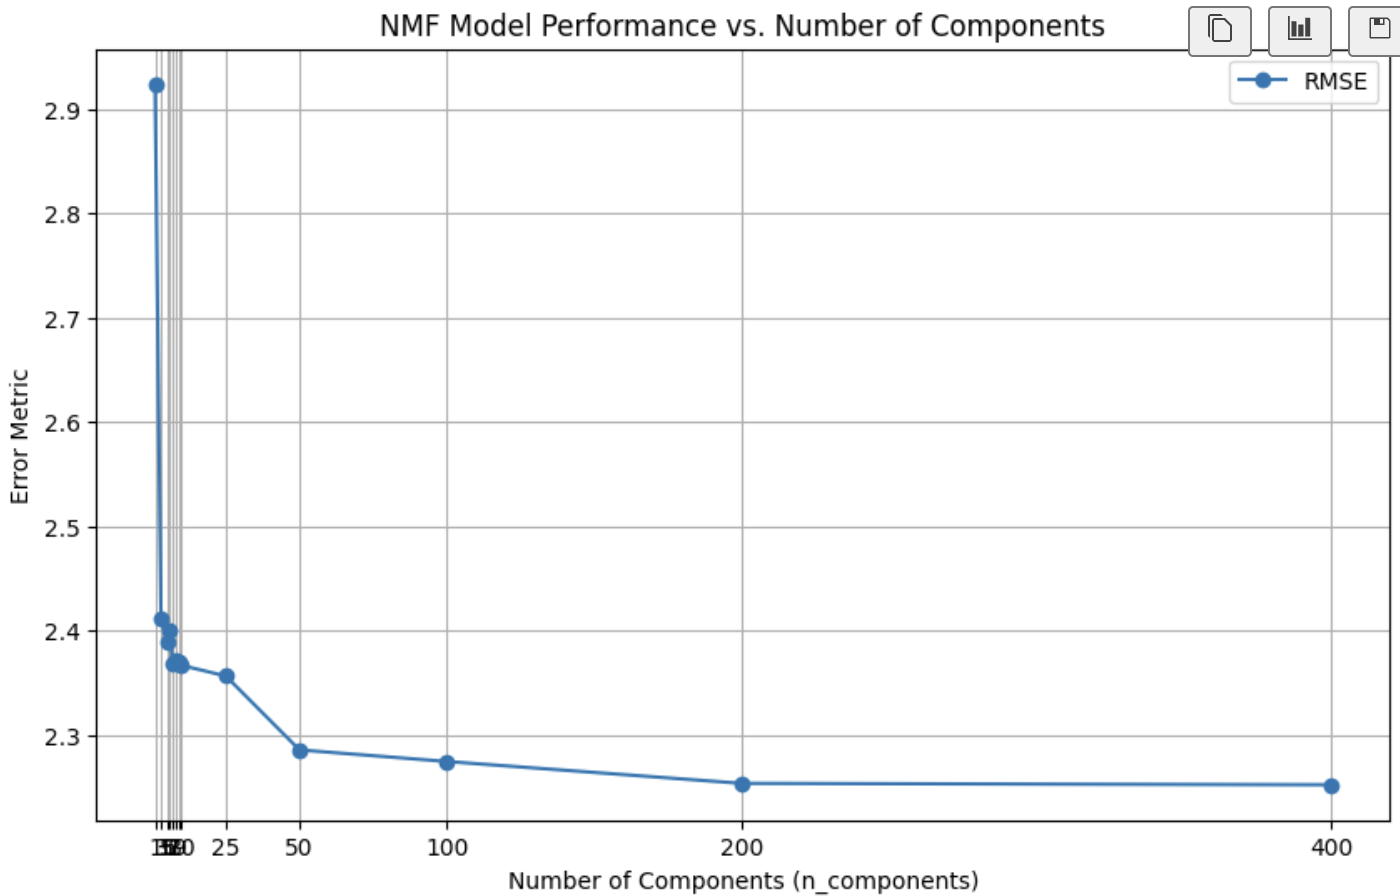

even though we see no significant increase here barely at all after 200 components, the recommendations and interesting patterns the model found definitely got better at following cells settings.

which proves RMSE isnt all you need to evaluate a model like this. Theres also user feedback in /letterboxd_testsets/profiles_readme.md

* note that im also testing on my own data, and not data from the actual dataset, which could be discussed if correct or not for various reasons, not only since my dataset is quite large compared to the average user in the training set
* another note is that i sadly lost the *exact* settings for generating the training matrix, but they are somewhat similar and will produce very, if not identical results. I just don't to train another model for hours. hence the empty outputs in this notebook.

In [ ]:
nmf_model, training_matrix = fit_model(
    user_movie_matrix_scaled,
    n_components=370,
    sample_size=1,
    max_iter=300,
)

In [ ]:
movie_ids = training_matrix.columns.tolist()
model_metadata = {
    'n_components': nmf_model.n_components,
    'trained_on': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
    'matrix_shape': training_matrix.shape,
    'scaling_method': 'z_score',
}


joblib.dump(nmf_model, 'model_files/nmf_model.joblib')
joblib.dump(movie_ids, 'model_files/movie_ids.joblib')
joblib.dump(model_metadata, 'model_files/model_metadata.joblib')